In [1]:
import numpy as np
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from torchmetrics.classification import MulticlassF1Score, MulticlassConfusionMatrix


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 5. Data Loading and Preparation

#### Loading

In [3]:
def load_dataset(data_dir):
    data = []
    subjects = range(1,41)
    trials = range(1,4)
    tasks = ['Arithmetic','Mirror_image','Stroop']

    for subject in subjects:
        for task in tasks:
            for trial in trials:
                filename = f"{task}_sub_{subject}_trial{trial}.mat"
                filepath = './Data/' + data_dir + '/' + filename
                
                try:
                    mat = loadmat(filepath)
                    if data_dir == 'raw_data' :
                        eeg_data = mat['Data']                       
                    else:
                        eeg_data = mat['Clean_data']  # Shape: (channels, time)
                    
                    data.append(eeg_data)
                except FileNotFoundError:
                    print(f"File {filename} not found. Skipping.")
    
    data = np.array(data)  # Shape: (samples, channels, time)
    
    return data


In [4]:
def load_labels(filename):
    tasks_mapping = {'Maths': 'Arithmetic', 'Symmetry': 'Mirror_image', 'Stroop': 'Stroop'}
    trials = [1, 2, 3]
    tasks_order = ['Maths', 'Symmetry', 'Stroop']
    subjects = range(1,41)
    
    # Load with multi-level headers
    filepath = './Data/' + filename
    df = pd.read_excel(filepath, header=[0, 1])
    
    # Initialize labels array: (subjects, trials, tasks)
    labels_array = np.zeros((40, 3, 3))

    for subj_idx, subject in enumerate(subjects):
        # Select the row for the current subject
        row = df.loc[df[('Subject No.', 'Unnamed: 0_level_1')] == subject]

        if row.empty:
            raise ValueError(f"Subject {subject} not found in the file.")

        row = row.squeeze()  # Convert single-row DataFrame to Series

        for trial_idx, trial_num in enumerate(trials):
            trial_name = f'Trial_{trial_num}'

            for task_idx, excel_task_name in enumerate(tasks_order):
                score = row[(trial_name, excel_task_name)]
                labels_array[subj_idx, trial_idx, task_idx] = int(score)

    return labels_array.reshape(-1)

#### Splitting dataset 

In [5]:
def split_data(data, labels, test_size=0.2, random_state=None):
    
    if random_state is not None:
        np.random.seed(random_state)  # Ensure reproducibility

    indices = np.arange(len(data))
    np.random.shuffle(indices)

    split_idx = int(len(data) * (1 - test_size))
    
    train_indices = indices[:split_idx]
    test_indices = indices[split_idx:]
    
    X_train = data[train_indices]
    y_train = labels[train_indices]
    X_test = data[test_indices]
    y_test = labels[test_indices]

    return X_train, X_test, y_train, y_test

In [6]:
class EEGDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)  # EEG data
        self.labels = torch.tensor(labels, dtype=torch.long)  # Labels as long for classification

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# 6. Model development

#### SimpleNN

In [7]:
class SimpleNN(nn.Module):
    def __init__(self, num_channels, num_timepoints, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(num_channels*num_timepoints, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten (channels, time)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Outputs raw scores for CrossEntropyLoss
        return x


#### EEG CNN

In [8]:
class EEG_CNN(nn.Module):
    def __init__(self, num_channels, num_timepoints, num_classes):
        super(EEG_CNN, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=num_channels, out_channels=64, kernel_size=7, stride=1, padding=3) #kernel = filter
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(kernel_size=2)

        # Compute the flattened size after convolutions and pooling
        conv_output_size = num_timepoints // (2 * 2 * 2)  # 3 poolings of size 2
        self.fc1 = nn.Linear(256 * conv_output_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # x: (batch_size, channels, time)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# 7. Model Training

In [9]:
def train_gen(data_folder,labels_file,num_classes, test_size=0.2, sampling_mode = None):
    """Generates the train and gives the number of the channels and the number of timepoints of the data

    Args:
        data_folder (string): name of the data folder
        labels_file (string): _description_
        num_classes (int): number of final classes
        test_size (float, optional): % of the data used for testing. Defaults to 0.2.
        sampling_mode (string, optional): undersampling of oversampling. Defaults to None.

    Returns:
       train_loader,test_loader, num_channels, num_timepoints
    """
    
    # Train gen
    data = load_dataset(data_folder)
    labels = load_labels(labels_file)
    num_channels, num_timepoints = data.shape[1], data.shape[2]
    
    labels = labels - 1

    ## Select how many classes do we want
    min_label, max_label = labels.min(), labels.max()
    #Create uniform bins
    bins = np.linspace(min_label, max_label, num_classes + 1)[1:-1]  # First and last excluded for np.digitize
    grouped_labels = np.digitize(labels, bins)
    
    # Split data
    X_train, X_test, y_train, y_test = split_data(data, grouped_labels, test_size=test_size, random_state=42)
    
    # Loader gen
    if sampling_mode == 'oversampling':
        X_train,y_train = random_oversample(X_train,y_train)
    elif sampling_mode == 'undersampling':
        X_train,y_train = random_undersample(X_train,y_train)
    else:
        pass
    
    # Datasets and DataLoaders
    train_dataset = EEGDataset(X_train, y_train)
    test_dataset = EEGDataset(X_test, y_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    return train_loader,test_loader, num_channels, num_timepoints

In [10]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_data, batch_labels in loader:
        # ⬇️ Transfert GPU
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == batch_labels).sum().item()
        total += batch_labels.size(0)

    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


In [11]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.0):
        """
        Early stops the training if validation loss doesn't improve after a given patience.
        """
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [12]:
def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_data, batch_labels in loader:
            # ⬇️ Transfert GPU
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_labels).sum().item()
            total += batch_labels.size(0)

    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

#### Apply this to both SimpleNN and EEG_CNN for fair comparison

In [13]:
def train_with_early_stopping(model, train_loader, val_loader,device, num_epochs=50, patience=7, lr=0.001, criterion=nn.CrossEntropyLoss()):
    """_summary_

    Args:
        model (_type_): _description_
        train_loader (_type_): _description_
        val_loader (_type_): _description_
        num_epochs (int, optional): _description_. Defaults to 50.
        patience (int, optional): _description_. Defaults to 7.
        lr (float, optional): _description_. Defaults to 0.001.
        criterion (_type_, optional): _description_. Defaults to nn.CrossEntropyLoss().

    Returns:
        _type_: _description_
    """
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    early_stopping = EarlyStopping(patience=patience)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    print(f"Using device: {device}")
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion,device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"🛑 Early stopping at epoch {epoch+1}.")
            break

    return model, history


In [14]:
num_classes = 3
train_loader,test_loader, num_channels, num_timepoints = train_gen('SKLFast_ICA_filtered_data','scales.xls',num_classes = num_classes)


# SimpleNN
simple_model = SimpleNN(num_channels,num_timepoints,num_classes).to(device)

# EEG_CNN
cnn_model = EEG_CNN(num_channels, num_timepoints, num_classes).to(device)

print("\n🔹 Training SimpleNN")
simple_model, simple_history = train_with_early_stopping(simple_model, train_loader, test_loader,device)

print("\n🔹 Training EEG_CNN")
cnn_model, cnn_history = train_with_early_stopping(cnn_model, train_loader, test_loader, device)



🔹 Training SimpleNN
Using device: cuda
Epoch [1/50] - Train Loss: 4.5915, Train Acc: 40.28% - Val Loss: 6.5006, Val Acc: 47.22%
Epoch [2/50] - Train Loss: 0.9589, Train Acc: 85.07% - Val Loss: 5.6702, Val Acc: 48.61%
Epoch [3/50] - Train Loss: 0.3332, Train Acc: 94.10% - Val Loss: 5.1806, Val Acc: 45.83%
Epoch [4/50] - Train Loss: 0.0413, Train Acc: 98.61% - Val Loss: 6.1151, Val Acc: 43.06%
Epoch [5/50] - Train Loss: 0.0126, Train Acc: 99.65% - Val Loss: 6.3328, Val Acc: 43.06%
Epoch [6/50] - Train Loss: 0.0097, Train Acc: 99.65% - Val Loss: 6.3982, Val Acc: 41.67%
Epoch [7/50] - Train Loss: 0.0088, Train Acc: 99.65% - Val Loss: 6.4375, Val Acc: 41.67%
Epoch [8/50] - Train Loss: 0.0077, Train Acc: 99.65% - Val Loss: 6.4607, Val Acc: 41.67%
Epoch [9/50] - Train Loss: 0.0071, Train Acc: 99.65% - Val Loss: 6.4732, Val Acc: 41.67%
Epoch [10/50] - Train Loss: 0.0068, Train Acc: 99.65% - Val Loss: 6.4803, Val Acc: 41.67%
🛑 Early stopping at epoch 10.

🔹 Training EEG_CNN
Using device: cuda


In [15]:
simple_final_acc = simple_history['val_acc'][-1]
cnn_final_acc = cnn_history['val_acc'][-1]

print("\n✅ Final Comparison:")
print(f"SimpleNN Final Validation Accuracy: {simple_final_acc:.2f}%")
print(f"EEG_CNN Final Validation Accuracy: {cnn_final_acc:.2f}%")



✅ Final Comparison:
SimpleNN Final Validation Accuracy: 41.67%
EEG_CNN Final Validation Accuracy: 43.06%


# 8. Evaluation and Insights

In [16]:
def plot_history(history, model_name):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.title(f"{model_name} Training History")
    plt.xlabel('Epoch')
    plt.ylabel('Loss / Accuracy')
    plt.legend()
    plt.show()


In [17]:
def evaluate_with_metrics_gpu(model, loader, device):
    model.eval()

    f1_metric = MulticlassF1Score(num_classes=3, average='weighted').to(device)
    cm_metric = MulticlassConfusionMatrix(num_classes=3).to(device)

    with torch.no_grad():
        for batch_data, batch_labels in loader:
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(batch_data)
            _, preds = torch.max(outputs, 1)

            f1_metric.update(preds, batch_labels)
            cm_metric.update(preds, batch_labels)

    f1_score_gpu = f1_metric.compute()
    confusion_matrix_gpu = cm_metric.compute()

    print(f"Weighted F1-score (GPU): {f1_score_gpu:.4f}")

    # Passage sur CPU et conversion en numpy
    cm_cpu = confusion_matrix_gpu.cpu().numpy()

    # 🔹 Normalisation par classe réelle (ligne)
    cm_normalized = cm_cpu.astype('float') / cm_cpu.sum(axis=1, keepdims=True)

    # Heatmap normalisée
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Low', 'Medium', 'High'],
                yticklabels=['Low', 'Medium', 'High'],
                cbar_kws={'label': 'Proportion'})
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')
    plt.show()


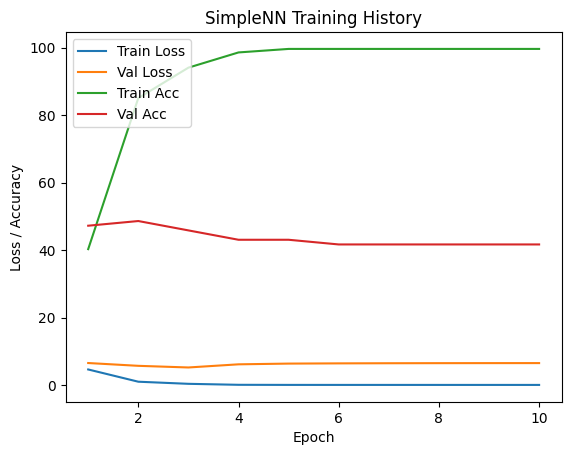

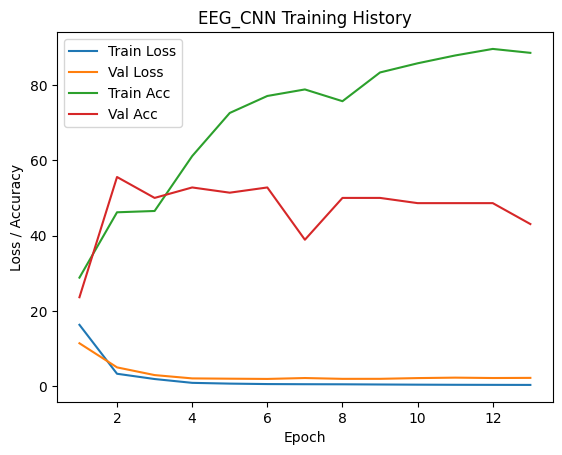

Weighted F1-score (GPU): 0.4410


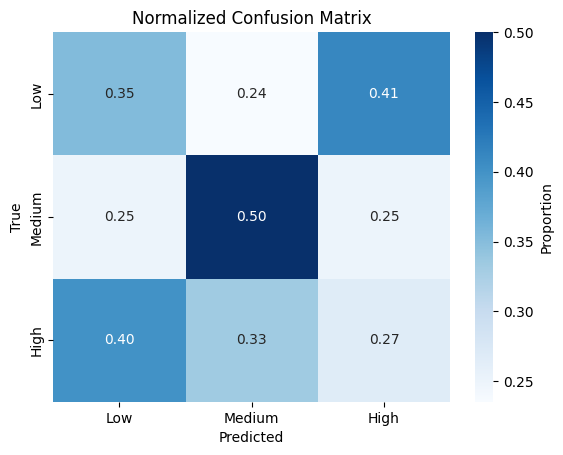

Weighted F1-score (GPU): 0.4301


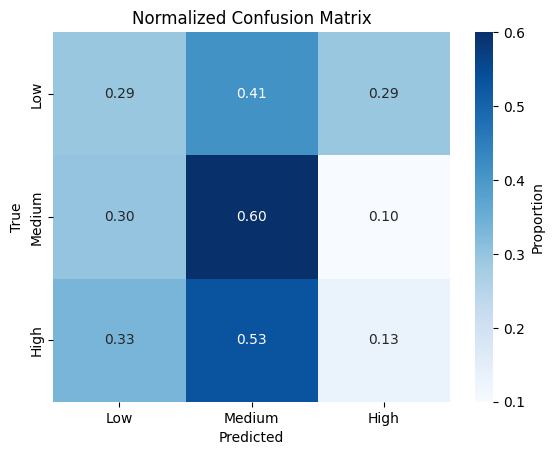

In [18]:
plot_history(simple_history, 'SimpleNN')
plot_history(cnn_history, 'EEG_CNN')
evaluate_with_metrics_gpu(simple_model, test_loader,device)
evaluate_with_metrics_gpu(cnn_model, test_loader,device)

We can notice that accuracy is not really good, maximum 50% can be obtained. One of the main problem is the distribution of the data, which is not uniform at all. Furthermore, the simple NN is reaching too quickly 100% accuracy on train set, which can be due to overfitting. 

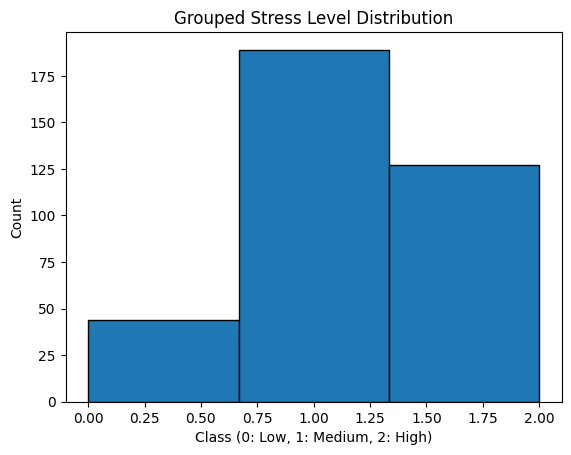

In [19]:
lb=load_labels('scales.xls')
grouped_labels= np.digitize(lb, bins=[3, 6]) # 0: 1-3, 1: 4-7, 2: 8-10
plt.hist(grouped_labels, bins=3, edgecolor='black')
plt.title("Grouped Stress Level Distribution")
plt.xlabel("Class (0: Low, 1: Medium, 2: High)")
plt.ylabel("Count")
plt.show()

# 9. Model Optimization

### 1st Problem : class distribution is not uniform

#### 1st solution : Weighted loss function

In [20]:
unique, counts = np.unique(grouped_labels, return_counts=True)
total_samples = sum(counts)
weights = [total_samples / c for c in counts]
weights = torch.tensor(weights, dtype=torch.float32)
weights = weights.to(device)
w_cross_entropy = nn.CrossEntropyLoss(weight=weights)

In [21]:
num_classes = 3
train_loader,test_loader , num_channels, num_timepoints = train_gen('filtered_data','scales.xls',num_classes = num_classes)


# SimpleNN
simple_model = SimpleNN(num_channels,num_timepoints,num_classes).to(device)

# EEG_CNN
cnn_model = EEG_CNN(num_channels, num_timepoints, num_classes).to(device)

print("\n🔹 Training SimpleNN with weighted loss function")
simple_model, simple_history = train_with_early_stopping(simple_model, train_loader, test_loader,device,criterion=w_cross_entropy)

print("\n🔹 Training EEG_CNN with weighted loss function")
cnn_model, cnn_history = train_with_early_stopping(cnn_model, train_loader, test_loader,device, criterion=w_cross_entropy)



🔹 Training SimpleNN with weighted loss function
Using device: cuda
Epoch [1/50] - Train Loss: 4.0848, Train Acc: 34.03% - Val Loss: 5.7689, Val Acc: 26.39%
Epoch [2/50] - Train Loss: 1.4812, Train Acc: 80.56% - Val Loss: 5.5197, Val Acc: 38.89%
Epoch [3/50] - Train Loss: 0.6305, Train Acc: 94.79% - Val Loss: 6.0351, Val Acc: 23.61%
Epoch [4/50] - Train Loss: 0.1843, Train Acc: 94.44% - Val Loss: 7.2002, Val Acc: 20.83%
Epoch [5/50] - Train Loss: 0.0015, Train Acc: 99.65% - Val Loss: 7.6575, Val Acc: 19.44%
Epoch [6/50] - Train Loss: 0.0001, Train Acc: 100.00% - Val Loss: 8.2684, Val Acc: 18.06%
Epoch [7/50] - Train Loss: 0.0000, Train Acc: 100.00% - Val Loss: 8.5777, Val Acc: 18.06%
Epoch [8/50] - Train Loss: 0.0000, Train Acc: 100.00% - Val Loss: 8.7085, Val Acc: 18.06%
Epoch [9/50] - Train Loss: 0.0000, Train Acc: 100.00% - Val Loss: 8.7616, Val Acc: 18.06%
🛑 Early stopping at epoch 9.

🔹 Training EEG_CNN with weighted loss function
Using device: cuda
Epoch [1/50] - Train Loss: 20.0


✅ Final Comparison:
SimpleNN Final Validation Accuracy: 18.06%
EEG_CNN Final Validation Accuracy: 38.89%


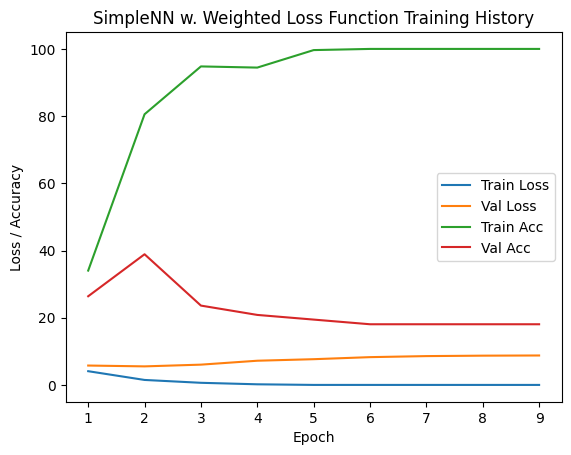

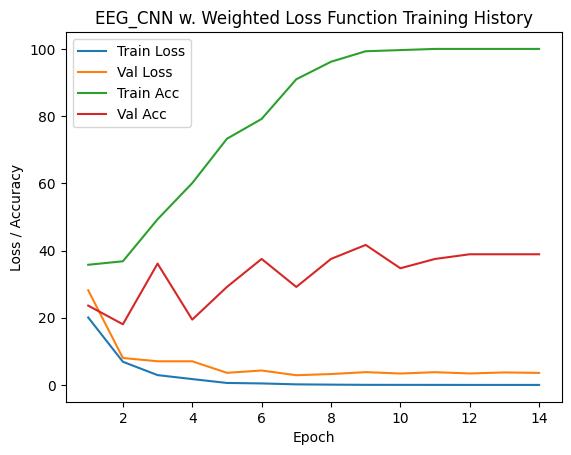

Weighted F1-score (GPU): 0.1699


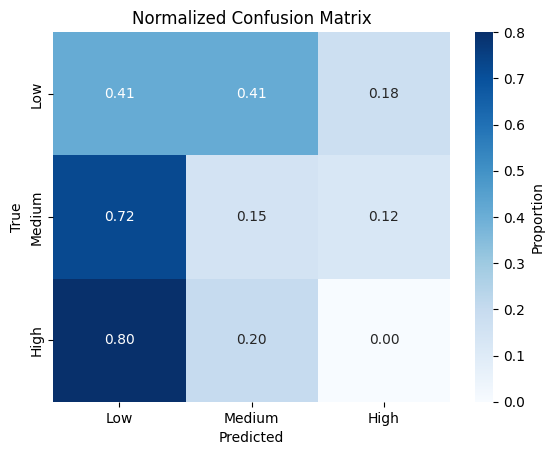

Weighted F1-score (GPU): 0.3778


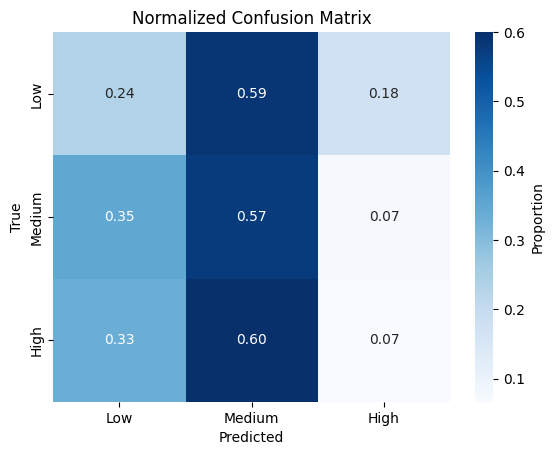

In [22]:
simple_final_acc = simple_history['val_acc'][-1]
cnn_final_acc = cnn_history['val_acc'][-1]

print("\n✅ Final Comparison:")
print(f"SimpleNN Final Validation Accuracy: {simple_final_acc:.2f}%")
print(f"EEG_CNN Final Validation Accuracy: {cnn_final_acc:.2f}%")

plot_history(simple_history, 'SimpleNN w. Weighted Loss Function')
plot_history(cnn_history, 'EEG_CNN w. Weighted Loss Function')
evaluate_with_metrics_gpu(simple_model, test_loader,device)
evaluate_with_metrics_gpu(cnn_model, test_loader,device)


#### 2nd solution : oversampling

In [23]:
def random_oversample(data, labels):

    unique_classes, counts = np.unique(labels, return_counts=True)
    max_count = counts.max()

    new_data = []
    new_labels = []

    for cls in unique_classes:
        cls_indices = np.where(labels == cls)[0]
        repeats = max_count // len(cls_indices)
        remainder = max_count % len(cls_indices)

        # Duplique les échantillons
        new_data.append(np.repeat(data[cls_indices], repeats, axis=0))
        new_labels.append(np.repeat(labels[cls_indices], repeats))

        if remainder > 0:
            chosen = np.random.choice(cls_indices, remainder, replace=False)
            new_data.append(data[chosen])
            new_labels.append(labels[chosen])

    data_balanced = np.vstack(new_data)
    labels_balanced = np.concatenate(new_labels)
    return data_balanced, labels_balanced


In [24]:
train_loader,test_loader, num_channels, num_timepoints = train_gen('filtered_data','scales.xls', sampling_mode='oversampling',num_classes = num_classes)

num_classes = 3



# SimpleNN
simple_model = SimpleNN(num_channels,num_timepoints,num_classes).to(device)

# EEG_CNN
cnn_model = EEG_CNN(num_channels, num_timepoints, num_classes).to(device)

print("\n🔹 Training SimpleNN with oversampling")
simple_model, simple_history = train_with_early_stopping(simple_model, train_loader, test_loader, device)

print("\n🔹 Training EEG_CNN with oversampling")
cnn_model, cnn_history = train_with_early_stopping(cnn_model, train_loader, test_loader, device)



🔹 Training SimpleNN with oversampling
Using device: cuda
Epoch [1/50] - Train Loss: 4.4509, Train Acc: 54.05% - Val Loss: 6.7683, Val Acc: 43.06%
Epoch [2/50] - Train Loss: 0.4962, Train Acc: 92.57% - Val Loss: 8.8609, Val Acc: 22.22%
Epoch [3/50] - Train Loss: 0.2043, Train Acc: 98.20% - Val Loss: 9.7892, Val Acc: 19.44%
Epoch [4/50] - Train Loss: 0.0858, Train Acc: 99.10% - Val Loss: 11.3864, Val Acc: 19.44%
Epoch [5/50] - Train Loss: 0.0055, Train Acc: 99.77% - Val Loss: 12.4809, Val Acc: 19.44%
Epoch [6/50] - Train Loss: 0.0001, Train Acc: 100.00% - Val Loss: 12.6994, Val Acc: 19.44%
Epoch [7/50] - Train Loss: 0.0000, Train Acc: 100.00% - Val Loss: 12.7569, Val Acc: 20.83%
Epoch [8/50] - Train Loss: 0.0000, Train Acc: 100.00% - Val Loss: 12.7680, Val Acc: 20.83%
🛑 Early stopping at epoch 8.

🔹 Training EEG_CNN with oversampling
Using device: cuda
Epoch [1/50] - Train Loss: 11.5700, Train Acc: 33.11% - Val Loss: 5.4980, Val Acc: 55.56%
Epoch [2/50] - Train Loss: 1.8546, Train Acc: 

##### Results plotting

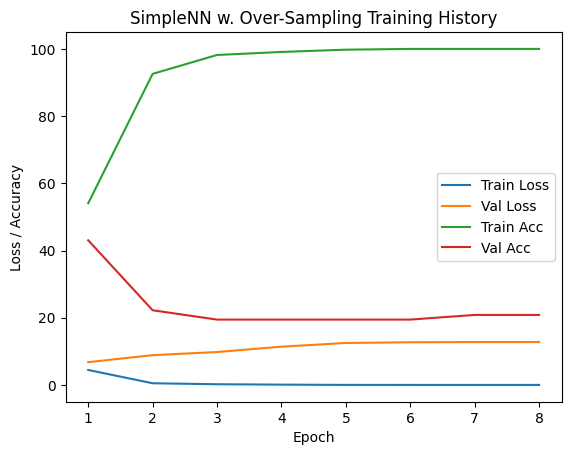

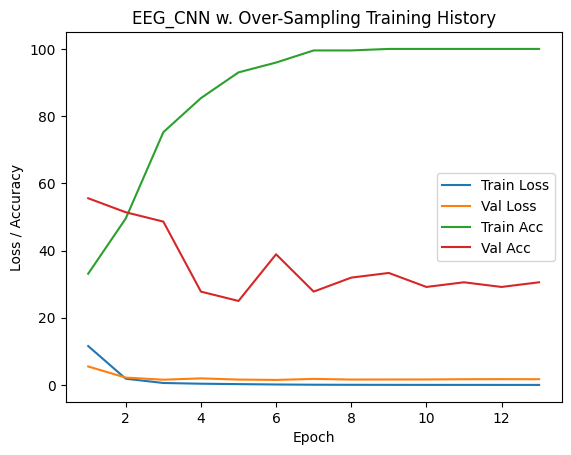

Weighted F1-score (GPU): 0.2162


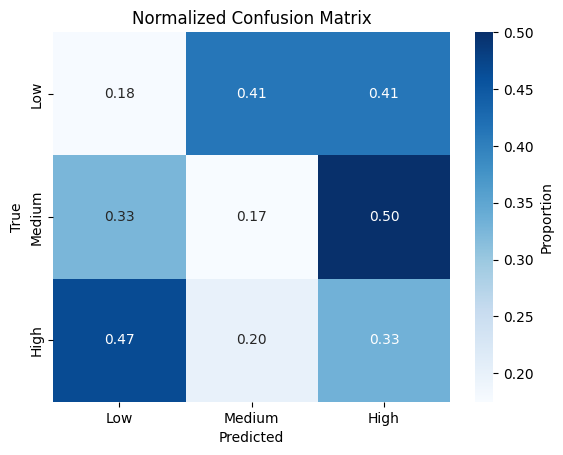

Weighted F1-score (GPU): 0.3080


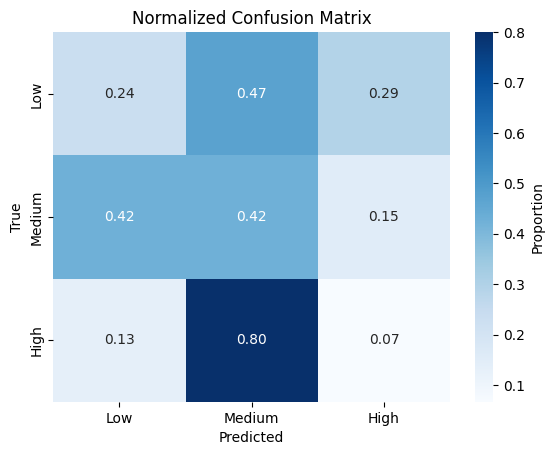

In [25]:
plot_history(simple_history, 'SimpleNN w. Over-Sampling')
plot_history(cnn_history, 'EEG_CNN w. Over-Sampling')
evaluate_with_metrics_gpu(simple_model, test_loader,device)
evaluate_with_metrics_gpu(cnn_model, test_loader,device)

#### 3rd solution : undersampling

In [26]:
def random_undersample(data, labels):
    from collections import Counter

    unique_classes, counts = np.unique(labels, return_counts=True)
    min_count = counts.min()

    new_data = []
    new_labels = []

    for cls in unique_classes:
        cls_indices = np.where(labels == cls)[0]
        selected = np.random.choice(cls_indices, min_count, replace=False)
        new_data.append(data[selected])
        new_labels.append(labels[selected])

    data_balanced = np.vstack(new_data)
    labels_balanced = np.concatenate(new_labels)
    return data_balanced, labels_balanced


In [27]:
train_loader,test_loader, num_channels, num_timepoints = train_gen('filtered_data','scales.xls',sampling_mode='undersampling',num_classes = num_classes)

num_classes = 3

# SimpleNN
simple_model = SimpleNN(num_channels,num_timepoints,num_classes).to(device)

# EEG_CNN
cnn_model = EEG_CNN(num_channels, num_timepoints, num_classes).to(device)

print("\n🔹 Training SimpleNN with undersampling")
simple_model, simple_history = train_with_early_stopping(simple_model, train_loader, test_loader,device)

print("\n🔹 Training EEG_CNN with undersampling")
cnn_model, cnn_history = train_with_early_stopping(cnn_model, train_loader, test_loader,device)



🔹 Training SimpleNN with undersampling
Using device: cuda
Epoch [1/50] - Train Loss: 4.4867, Train Acc: 29.09% - Val Loss: 6.0203, Val Acc: 33.33%
Epoch [2/50] - Train Loss: 0.4974, Train Acc: 93.33% - Val Loss: 7.5974, Val Acc: 37.50%
Epoch [3/50] - Train Loss: 0.0364, Train Acc: 99.39% - Val Loss: 8.3880, Val Acc: 36.11%
Epoch [4/50] - Train Loss: 0.1181, Train Acc: 98.18% - Val Loss: 9.8957, Val Acc: 33.33%
Epoch [5/50] - Train Loss: 0.0329, Train Acc: 98.79% - Val Loss: 10.2009, Val Acc: 31.94%
Epoch [6/50] - Train Loss: 0.0081, Train Acc: 99.39% - Val Loss: 10.3442, Val Acc: 30.56%
Epoch [7/50] - Train Loss: 0.0001, Train Acc: 100.00% - Val Loss: 10.8385, Val Acc: 33.33%
Epoch [8/50] - Train Loss: 0.0000, Train Acc: 100.00% - Val Loss: 11.1336, Val Acc: 34.72%
🛑 Early stopping at epoch 8.

🔹 Training EEG_CNN with undersampling
Using device: cuda
Epoch [1/50] - Train Loss: 26.9671, Train Acc: 34.55% - Val Loss: 19.5028, Val Acc: 23.61%
Epoch [2/50] - Train Loss: 6.1029, Train Acc:

##### Results plotting

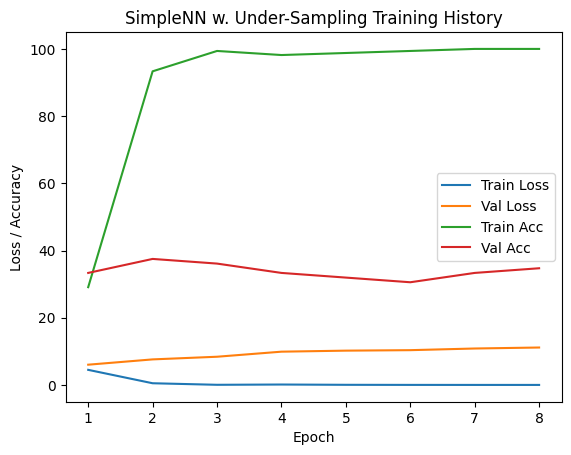

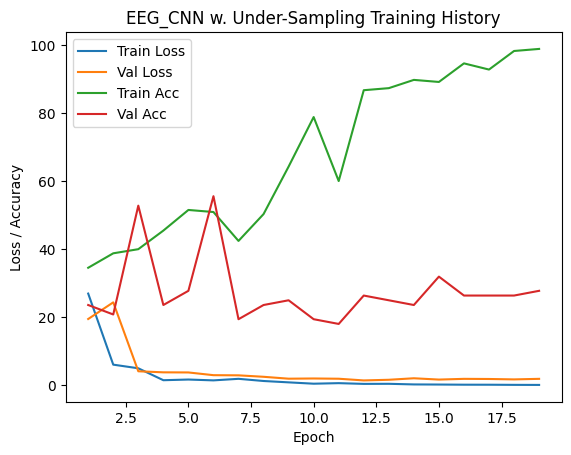

Weighted F1-score (GPU): 0.3502


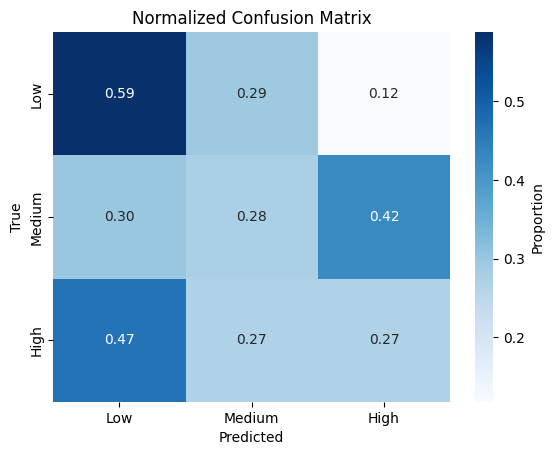

Weighted F1-score (GPU): 0.2506


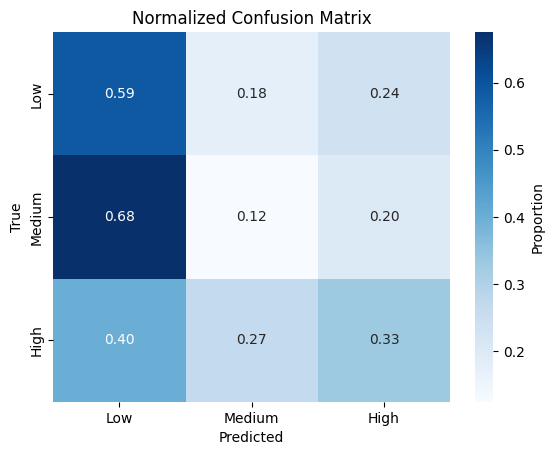

In [28]:
plot_history(simple_history, 'SimpleNN w. Under-Sampling')
plot_history(cnn_history, 'EEG_CNN w. Under-Sampling')
evaluate_with_metrics_gpu(simple_model, test_loader,device)
evaluate_with_metrics_gpu(cnn_model, test_loader,device)

### 2nd problem : Neural-Networks are overfitting

Solution for Simple-NN : reduction of the number of neurones, adding of dropout and batchnorm layers.

In [29]:
class SimpleNN2(nn.Module):
    def __init__(self, num_channels, num_timepoints, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(num_channels*num_timepoints, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.4)
        
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.4)
        
        self.fc3 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.dropout1(F.relu(self.bn1(self.fc1(x))))
        x = self.dropout2(F.relu(self.bn2(self.fc2(x))))
        x = self.fc3(x)
        return x


Solution for CNN : reduce the number of filters, add dropout layer, reduce deepness of the network

In [30]:
class EEG_CNN2(nn.Module):
    def __init__(self, num_channels, num_timepoints, num_classes):
        super().__init__()
        
        self.conv1 = nn.Conv1d(in_channels=num_channels, out_channels=32, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.dropout1 = nn.Dropout(0.3)
        self.pool1 = nn.MaxPool1d(2)
        
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)
        self.pool2 = nn.MaxPool1d(2)
        
        conv_output_size = num_timepoints // 4  # Deux maxpoolings de taille 2
        self.fc1 = nn.Linear(64 * conv_output_size, 64)
        self.dropout3 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)
        
        x = x.view(x.size(0), -1)
        x = self.dropout3(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


Test : 

In [31]:
train_loader,test_loader, num_channels, num_timepoints = train_gen('filtered_data','scales.xls',num_classes = num_classes)
num_classes = 3



# SimpleNN
simple_model2 = SimpleNN2(num_channels,num_timepoints,num_classes).to(device)

# EEG_CNN
cnn_model2 = EEG_CNN2(num_channels, num_timepoints, num_classes).to(device)

print("\n🔹 Training SimpleNN2")
simple_model2, simple_history2 = train_with_early_stopping(simple_model2, train_loader, test_loader,device)

print("\n🔹 Training EEG_CNN2")
cnn_model2, cnn_history2 = train_with_early_stopping(cnn_model2, train_loader, test_loader,device)



🔹 Training SimpleNN2
Using device: cuda
Epoch [1/50] - Train Loss: 1.1941, Train Acc: 36.81% - Val Loss: 1.1953, Val Acc: 30.56%
Epoch [2/50] - Train Loss: 0.9742, Train Acc: 52.43% - Val Loss: 1.1378, Val Acc: 22.22%
Epoch [3/50] - Train Loss: 0.9168, Train Acc: 56.94% - Val Loss: 1.1247, Val Acc: 20.83%
Epoch [4/50] - Train Loss: 0.8712, Train Acc: 66.67% - Val Loss: 1.1098, Val Acc: 25.00%
Epoch [5/50] - Train Loss: 0.8381, Train Acc: 67.36% - Val Loss: 1.1030, Val Acc: 23.61%
Epoch [6/50] - Train Loss: 0.7925, Train Acc: 70.83% - Val Loss: 1.0935, Val Acc: 29.17%
Epoch [7/50] - Train Loss: 0.7300, Train Acc: 75.35% - Val Loss: 1.0905, Val Acc: 33.33%
Epoch [8/50] - Train Loss: 0.6765, Train Acc: 77.08% - Val Loss: 1.0887, Val Acc: 36.11%
Epoch [9/50] - Train Loss: 0.6296, Train Acc: 84.72% - Val Loss: 1.0884, Val Acc: 36.11%
Epoch [10/50] - Train Loss: 0.5538, Train Acc: 84.03% - Val Loss: 1.0869, Val Acc: 36.11%
Epoch [11/50] - Train Loss: 0.5463, Train Acc: 85.42% - Val Loss: 1.

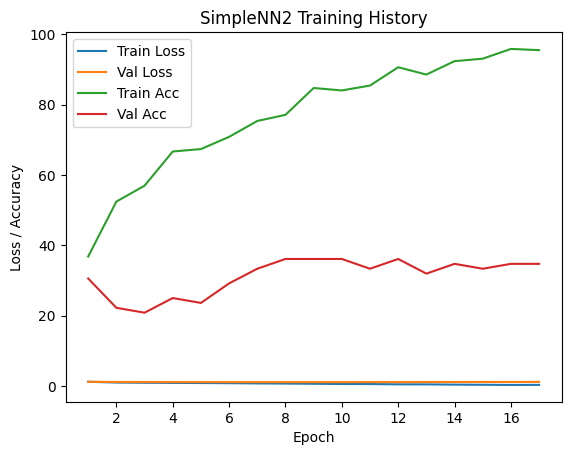

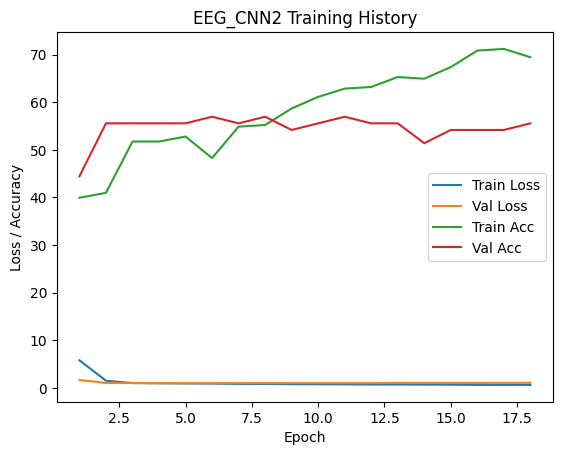

In [32]:
plot_history(simple_history2, 'SimpleNN2')
plot_history(cnn_history2, 'EEG_CNN2')

Weighted F1-score (GPU): 0.3180


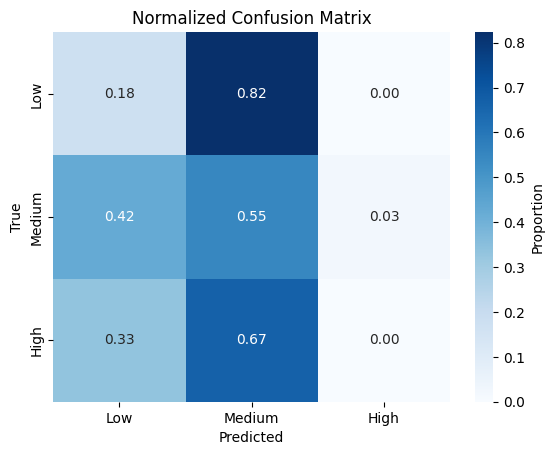

Weighted F1-score (GPU): 0.4610


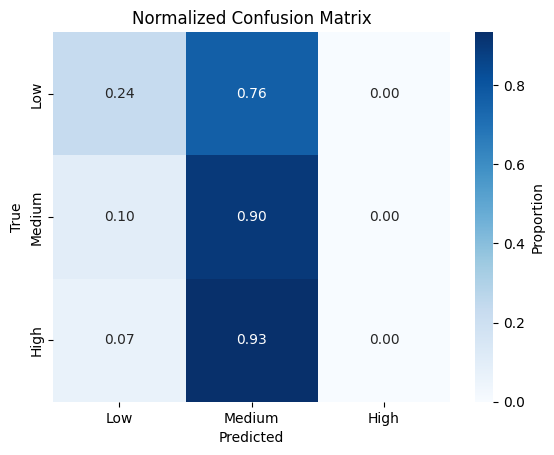

In [33]:
evaluate_with_metrics_gpu(simple_model2, test_loader,device)
evaluate_with_metrics_gpu(cnn_model2, test_loader,device)

Solution 3 : EEG Hybrid CNN + GRU

In [34]:
class EEG_CNN_GRU(nn.Module):
    def __init__(self, num_channels, num_timepoints, num_classes):
        super().__init__()
        
        # CNN
        self.conv1 = nn.Conv1d(num_channels, 64, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(2)
        self.dropout1 = nn.Dropout(0.3)

        # GRU
        gru_input_size = num_timepoints // 2  # after pooling
        self.gru = nn.GRU(input_size=64, hidden_size=64, batch_first=True)


        # Fully connected
        self.fc1 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        # CNN feature extraction
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # GRU expects (batch, seq_len, feature), so we permute
        x = x.permute(0, 2, 1)  # (batch_size, time_steps, features)

        # GRU
        _, h_n = self.gru(x)  # we take the last hidden state
        x = h_n.squeeze(0)  # (batch_size, hidden_size)

        # Fully connected layers
        x = self.dropout2(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [35]:
train_loader,test_loader, num_channels, num_timepoints = train_gen('filtered_data','scales.xls',num_classes = num_classes)

num_classes = 3


# EEG_Hydrid_CNN_+_GRU

hybrid_cnn_model = EEG_CNN_GRU(num_channels, num_timepoints, num_classes).to(device)

print("\n🔹 Training Hybrid CNN + GRU")
hybrid_cnn_model, hybrid_cnn_history = train_with_early_stopping(hybrid_cnn_model, train_loader, test_loader,device)



🔹 Training Hybrid CNN + GRU
Using device: cuda
Epoch [1/50] - Train Loss: 1.1029, Train Acc: 34.38% - Val Loss: 1.0456, Val Acc: 55.56%
Epoch [2/50] - Train Loss: 1.0437, Train Acc: 46.88% - Val Loss: 1.0219, Val Acc: 55.56%
Epoch [3/50] - Train Loss: 1.0136, Train Acc: 51.04% - Val Loss: 1.0242, Val Acc: 55.56%
Epoch [4/50] - Train Loss: 1.0172, Train Acc: 50.00% - Val Loss: 1.0321, Val Acc: 55.56%
Epoch [5/50] - Train Loss: 1.0150, Train Acc: 48.96% - Val Loss: 1.0363, Val Acc: 55.56%
Epoch [6/50] - Train Loss: 0.9963, Train Acc: 49.65% - Val Loss: 1.0514, Val Acc: 55.56%
Epoch [7/50] - Train Loss: 0.9654, Train Acc: 53.82% - Val Loss: 1.0572, Val Acc: 55.56%
Epoch [8/50] - Train Loss: 0.9675, Train Acc: 53.82% - Val Loss: 1.0497, Val Acc: 55.56%
Epoch [9/50] - Train Loss: 0.9471, Train Acc: 52.78% - Val Loss: 1.0475, Val Acc: 55.56%
🛑 Early stopping at epoch 9.


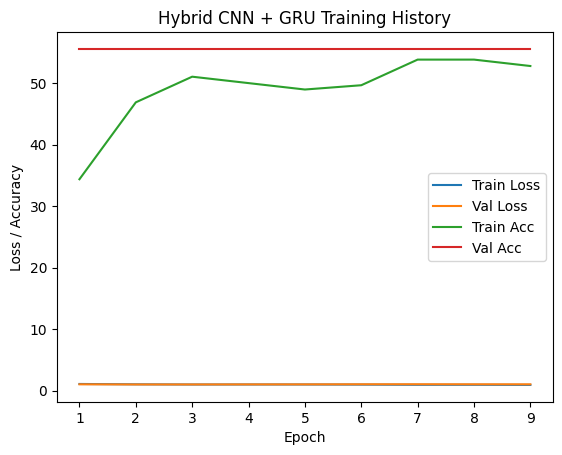

Weighted F1-score (GPU): 0.3968


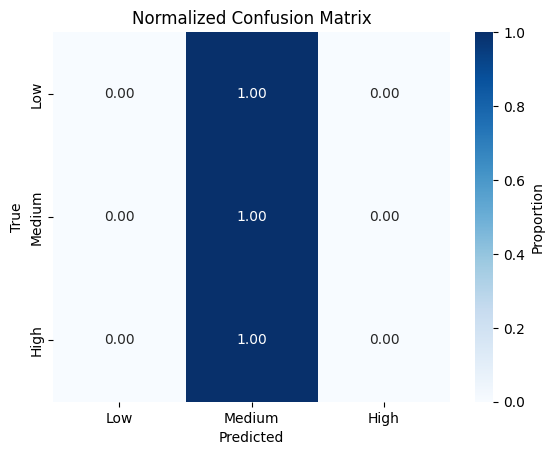

In [36]:
plot_history(hybrid_cnn_history , 'Hybrid CNN + GRU')
evaluate_with_metrics_gpu(hybrid_cnn_model, test_loader,device)